In [1]:
import numpy as np
import pandas as pd
import pickle
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import joblib 

<ipython-input-1-119d1d15d091>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home3/xxxs67/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/xxxs67/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home3/xxxs67/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("dataset (4).csv")

In [4]:
df.shape

(59621, 2)

In [5]:
df.head()

,Score,Text
0,4.0,"It is a nice made necklace, and the butterfly ..."
1,4.0,I bought this necklace on a whim; I love butte...
2,5.0,"Bought via gold box ,it is much better than I ..."
3,NaN,I love this necklace. It is great for everyday...
4,5.0,"Love this butterfly pendant. Right size, high ..."


In [6]:
df.dtypes

Score    float64
Text      object
dtype: object

In [7]:
# Loading a set of common English stopwords to filter out non-informative words.
common_stopwords = set(stopwords.words('english'))  

# Initializing the WordNetLemmatizer, which reduces words to their base or root form.
word_lemmatizer = WordNetLemmatizer()  

def clean_text(text):
    """
    Function to preprocess text data by performing the following steps:
    1. Handling missing values by replacing NaN with an empty string.
    2. Converting all text to lowercase to ensure uniformity.
    3. Removing punctuation (except apostrophes) to clean up the text.
    4. Tokenizing the text into individual words.
    5. Identifying and handling negations (e.g., "not happy" → "not_happy").
    6. Removing common stopwords to retain only meaningful words.
    7. Applying lemmatization to convert words to their base form.
    8. Returning the cleaned and processed text as a single string.
    """

    # Handling missing values
    # If the input text is NaN (missing value),we are replacing it with an empty string
    text = text if pd.notna(text) else ''
    
    # Converting text to lowercase
    # This ensures uniformity and prevents duplicate words due to case differences 
    text = text.lower()
    
    # Removing punctuation while preserving apostrophes
    # `str.maketrans('', '', string.punctuation.replace("'", ""))` creates a translation table.
    # It removes all punctuation characters except apostrophes to retain contractions.
    text = text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
   
    # Tokenization for splitting the text into individual words (tokens).
    # This helps in further processing like removing stopwords and lemmatization.
    tokens = word_tokenize(text)

    # Defining negation words that need special handling.
    negations = {"not", "no", "never", "isn't", "aren't", "wasn't", "weren't", 
                 "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", 
                 "shouldn't", "can't", "cannot"}

    # Initializing a list to store the processed tokens.
    processed_tokens = []
    
    # Processing tokens while handling negations and removing stopwords.
    i = 0  # Initialize a counter for iteration over tokens.
    while i < len(tokens):  # Iterate through the list of tokens.
        if tokens[i] in negations and i + 1 < len(tokens):  
            # If a negation word is found and there's a word after it, combine them into a single token.
            # Example: "not good" becomes "not_good".
            processed_tokens.append(tokens[i] + "_" + tokens[i + 1])
            i += 2  # Skip the next word since it's already combined.
        else:
            # Applying lemmatization to convert the word to its base form.
            word = word_lemmatizer.lemmatize(tokens[i])
            
            # Removing stopwords and single-character words.
            # Stopwords are common words like "is", "the", and "in" that do not contribute much meaning.
            # Words with only one character (e.g., "a", "I") are also removed.
            if word not in common_stopwords and len(word) > 1:
                processed_tokens.append(word)  # Add meaningful words to the final token list.
            
            i += 1  # Move to the next word.
    
    # 10. Convert the processed token list back into a single string.
    # If the processed token list is empty (e.g., if all words were stopwords), return None.
    return ' '.join(processed_tokens) if processed_tokens else None  


In [8]:
# Apply the text preprocessing function to each row in the 'Text' column  
# This ensures all text data is cleaned before further analysis  
# The function handles missing values, converts to lowercase, removes punctuation, tokenizes, removes stopwords, and applies lemmatization  
df['Cleaned_Text'] = df['Text'].apply(clean_text)

In [9]:
# Remove empty or very short reviews (ensures meaningful data for analysis)  
# Splits text into words and keeps only those reviews with more than one word  
# Also drops any remaining NaN values for robustness  
df = df[df['Cleaned_Text'].str.split().str.len() > 1].dropna()

In [10]:
# Convert categorical labels here scores into numerical values  
# This allows ML models to process them effectively  
label_encoder = LabelEncoder()  
df['Encoded_Score'] = label_encoder.fit_transform(df['Score'])  

In [11]:
df.head()

,Score,Text,Cleaned_Text,Encoded_Score
0,4.0,"It is a nice made necklace, and the butterfly ...",nice made necklace butterfly pendant look beau...,3
1,4.0,I bought this necklace on a whim; I love butte...,bought necklace whim love butterfly looked dai...,3
2,5.0,"Bought via gold box ,it is much better than I ...",bought via gold box much better thoughtthe cha...,4
4,5.0,"Love this butterfly pendant. Right size, high ...",love butterfly pendant right size high quality...,4
5,5.0,I bought this as a graduation gift for my daug...,bought graduation gift daughter wanted ring re...,4


In [12]:
df.shape

(50830, 4)

In [13]:
# Checking the distribution of ratings
rating_counts = df['Score'].value_counts()
print("Distribution of Ratings:\n", rating_counts)


Distribution of Ratings:
 Score
5.0    27772
4.0    10241
3.0     5129
1.0     4405
2.0     3283
Name: count, dtype: int64


In [14]:
# Train-test split using the cleaned text and encoded labels  
# `test_size=0.2` reserves 20% of data for testing  
# `stratify=df['Encoded_Score']` ensures balanced class distribution in train & test sets  
# `random_state=42` ensures reproducibility  
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Text'], df['Encoded_Score'], test_size=0.2, stratify=df['Encoded_Score'], random_state=42)


In [15]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (40664,)
Test data shape: (10166,)


In [16]:
# Creating a pipeline that first transforms text data into numerical features using TF-IDF
# Then, it applies a Naive Bayes classifier to make predictions
nb_model = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),  # Convert text into TF-IDF features, considering both unigrams and bigrams
    MultinomialNB(alpha=0.1)  # Using Naive Bayes with a smoothing factor of 0.5 to handle zero probabilities
)

# Training the model using the training dataset (X_train contains text, y_train contains labels)
nb_model.fit(X_train, y_train)

# Making predictions on the test dataset
nb_predicted = nb_model.predict(X_test)

# Displaying some sample predictions along with actual values to compare
print("First 15 predicted labels:", nb_predicted[:15])  # Showing the first 15 predictions made by the model
print("First 15 actual labels:", y_test.values[:15])  # Displaying the corresponding actual labels

# Printing a detailed classification report to evaluate the model’s performance
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, nb_predicted))  # Shows precision, recall, and F1-score for each class

First 15 predicted labels: [0 4 3 4 4 0 4 4 4 4 2 4 2 0 4]
First 15 actual labels: [0 2 4 4 4 0 1 4 2 4 2 4 0 0 4]

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       881
           1       0.96      0.23      0.36       657
           2       0.79      0.26      0.40      1026
           3       0.58      0.32      0.41      2048
           4       0.67      0.98      0.80      5554

    accuracy                           0.68     10166
   macro avg       0.77      0.45      0.51     10166
weighted avg       0.70      0.68      0.63     10166



k=1: Avg. Cross-Validation Accuracy = 0.608
k=3: Avg. Cross-Validation Accuracy = 0.639
k=5: Avg. Cross-Validation Accuracy = 0.659
k=7: Avg. Cross-Validation Accuracy = 0.669
k=9: Avg. Cross-Validation Accuracy = 0.676

First 10 predicted labels: [0 4 4 4 4 0 4 4 4 4]
First 10 actual labels: [0 2 4 4 4 0 1 4 2 4]


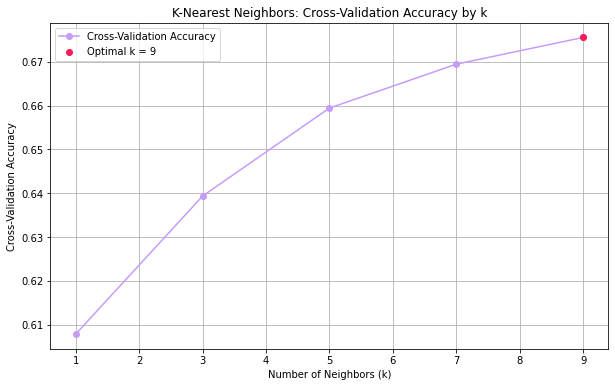

In [17]:
# The goal is to find the best k (number of neighbors) for KNN classification.
k_neighbors_list = [1, 3, 5, 7, 9]  # List of k values to evaluate
cross_validation_scores = []  # This will store the average accuracy for each k-value.

# Iterating over different k-values and perform cross-validation
for k in k_neighbors_list:
    # Creating a pipeline that first converts text into numerical features (TF-IDF)
    # and then applies the K-Nearest Neighbors classifier.
    knn_model = make_pipeline(
        TfidfVectorizer(ngram_range=(1, 2), max_features=50000, sublinear_tf=True),
        # TF-IDF Vectorizer:
        # Converts text into numerical features for ML models.
        # Uses unigrams (single words) and bigrams (word pairs).
        # Limits features to 50,000 to reduce computational cost.
        # Uses sublinear TF scaling to dampen the effect of frequently occurring words.

        KNeighborsClassifier(n_neighbors=k, metric='cosine', weights='distance')
        # K-Nearest Neighbors (KNN) Classifier:
        # `n_neighbors=k`: Specifies the number of neighbors to consider.
        # `metric='cosine'`: Uses cosine similarity instead of Euclidean distance (better for text data).
        # `weights='distance'`: Weights closer neighbors more heavily in decision-making.
    )

    # Evaluating the model using cross-validation
    # 5-fold cross-validation splits the data into 5 parts and evaluates the model 5 times.
    # We measure accuracy in each fold and take the average.
    cv_accuracy_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')

    # Storing the average accuracy for this k-value
    cross_validation_scores.append(cv_accuracy_scores.mean())

    # Printing the results to track how the model performs for each k-value.
    print(f"k={k}: Avg. Cross-Validation Accuracy = {cv_accuracy_scores.mean():.3f}")

# Finding the best k-value based on highest accuracy
optimal_k = k_neighbors_list[np.argmax(cross_validation_scores)]

# Training the final model using the best k-value found
final_knn_model = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), max_features=50000, sublinear_tf=True),
    KNeighborsClassifier(n_neighbors=optimal_k, metric='cosine', weights='distance')
)

# Fitting the final model on the full training dataset
final_knn_model.fit(X_train, y_train)

# Making predictions on the test dataset
knn_pred = final_knn_model.predict(X_test)

# Displaying a sample of predictions to compare with actual labels
print("\nFirst 10 predicted labels:", knn_pred[:10])
print("First 10 actual labels:", y_test.values[:10])

# Plotting k-values against their corresponding cross-validation accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_neighbors_list, cross_validation_scores, marker='o', linestyle='-', color='#c69bfa', label='Cross-Validation Accuracy')

# Highlighting the optimal k value
plt.scatter(optimal_k, max(cross_validation_scores), color='#fa1b57', zorder=5, label=f'Optimal k = {optimal_k}')

# Adding title and labels
plt.title('K-Nearest Neighbors: Cross-Validation Accuracy by k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')

# Adding a grid for better readability
plt.grid(True)

# Adding a legend
plt.legend()

# Displaying the graph
plt.show()

In [18]:
# Define and fit the tokenizer
MAX_NB_WORDS = 50000  # Define the maximum vocabulary size for tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  
tokenizer.fit_on_texts(X_train)  # Fit tokenizer only on training data

In [19]:
# Setting random seeds for consistent results
np.random.seed(42)
tf.random.set_seed(42)

# Defining key parameters for model training
MAX_SEQUENCE_LENGTH = 300  # Standardizing sequence length to 300 
EMBEDDING_DIM = 100  # Each word will be represented as a 100-dimensional vector

# Converting training and test text data into sequences of integers
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

# Ensuring all sequences are of the same length (MAX_SEQUENCE_LENGTH)
# If a sequence is shorter, it is padded; if longer, it is truncated
X_train_padded = pad_sequences(X_train_sequence, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Converting categorical labels into one-hot encoding format
# This is required for multi-class classification tasks
y_train_categorical = tf.keras.utils.to_categorical(y_train)
y_test_categorical = tf.keras.utils.to_categorical(y_test)

# defining the Convolutional Neural Network model
cnn_model = Sequential()  # Using a sequential model where layers are stacked

# Adding an embedding layer to convert word indices into dense vectors
# This layer transforms words into a meaningful numerical representation
cnn_model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# First convolutional layer
# Uses 128 filters with a kernel size of 5, followed by ReLU activation
# Helps capturing local word patterns
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))  # Downsamples the feature maps to reduce size

# Second convolutional layer
# Another Conv1D layer with the same configuration to extract deeper features
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))  # Further reduces dimensionality

# Global Max Pooling layer to reduce the feature map to a fixed-size vector
# Selects the maximum value for each feature, keeping the most significant ones
cnn_model.add(GlobalMaxPooling1D())

# Fully connected layer
# Includes 128 neurons with ReLU activation for learning high-level patterns
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Drops 50% of neurons during training to prevent overfitting

# Output layer
# Number of neurons = number of classes (from y_train_cat.shape[1])
# Uses softmax activation for multi-class probability distribution
cnn_model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
# Uses Adam optimizer, categorical cross-entropy loss (for multi-class problems), and accuracy as a metric
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
# Uses batch size of 64, runs for 5 epochs, and validates on test data
history = cnn_model.fit(X_train_padded, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test_categorical))

# Predicting class probabilities for test data
cnn_pred = cnn_model.predict(X_test_padded)
# Converting probability predictions into class labels
cnn_pred_class = np.argmax(cnn_pred, axis=1)

# Printing classification report to evaluate model performance
print("Classification Report for CNN:")
print(classification_report(y_test, cnn_pred_class))


Epoch 1/5
636/636 [==============================] - 90s 140ms/step - loss: 0.9773 - accuracy: 0.6067 - val_loss: 0.8226 - val_accuracy: 0.6636
Epoch 2/5
636/636 [==============================] - 90s 141ms/step - loss: 0.7141 - accuracy: 0.7166 - val_loss: 0.7871 - val_accuracy: 0.6902
Epoch 3/5
636/636 [==============================] - 90s 141ms/step - loss: 0.5374 - accuracy: 0.7908 - val_loss: 0.8585 - val_accuracy: 0.6934
Epoch 4/5
636/636 [==============================] - 90s 141ms/step - loss: 0.3991 - accuracy: 0.8487 - val_loss: 1.0185 - val_accuracy: 0.6738
Epoch 5/5
318/318 [==============================] - 4s 13ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       881
           1       0.38      0.42      0.40       657
           2       0.44      0.43      0.44      1026
           3       0.57      0.39      0.46      2048
           4       0.80      0.91      0.85      5554

 

In [20]:
# Setting random seeds for consistent results
np.random.seed(42)
tf.random.set_seed(42)

# Defining constants
MAX_SEQUENCE_LENGTH = 200  # Standardized sequence length - Reduced from 300 for efficiency
EMBEDDING_DIM = 128       # Word embedding dimension - Increased from 100 to capture more features
BATCH_SIZE = 128          # Number of samples processed before updating the model
EPOCHS = 10               # Number of training iterations over the dataset

# Converting text into sequences
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

# Ensuring all sequences are the same length i.e. either padded or truncated
X_train_padded = pad_sequences(X_train_sequence, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequence, maxlen=MAX_SEQUENCE_LENGTH)

# One-hot encoding is done to convert target labels into categorical format for multi-class classification
y_train_categorical = tf.keras.utils.to_categorical(y_train)  # Converting y_train into one-hot encoding
y_test_categorical = tf.keras.utils.to_categorical(y_test)    # Converting y_test into one-hot encoding

# Building model
# Defining a sequential neural network model
lstm_model = Sequential([
    # Embedding layer used to convert word indices into dense vectors
    Embedding(input_dim=MAX_NB_WORDS,  # Vocabulary size
              output_dim=EMBEDDING_DIM,  # Vector dimension per word
              input_length=MAX_SEQUENCE_LENGTH),  # Input sequence length
    
    # Spatial Dropout randomly drops words during training to improve generalization
    SpatialDropout1D(0.2),  # 20% dropout
    
    # First LSTM layer: Bi-directional for better context capture
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),  # 64 LSTM units with dropout
    
    # Second LSTM layer: Another bi-directional LSTM for deeper sequence learning
    Bidirectional(LSTM(64, dropout=0.2)),  # 64 LSTM units with dropout
    
    # Fully connected layer: 64 neurons with ReLU activation to extract features
    Dense(64, activation='relu'),  # Activation function introduces non-linearity
    
    # Dropout layer: Prevents overfitting by randomly setting neurons to zero
    Dropout(0.3),  # 30% dropout
    
    # Output layer: Softmax activation to predict class probabilities
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output neurons = number of classes
])

# Compiling the model with an optimizer, loss function, and evaluation metric
lstm_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Adam optimizer with a small learning rate for stability
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Accuracy metric to evaluate performance
)

# Training
# Defining early stopping: Stop training if validation loss doesn't improve for 2 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training the model with training data and validating on test data
history = lstm_model.fit(
    X_train_padded, y_train_categorical,
    epochs=EPOCHS,  # Run for a fixed number of epochs
    batch_size=BATCH_SIZE,  # Number of samples processed before model update
    validation_data=(X_test_padded, y_test_categorical),  # Using test data for validation
    callbacks=[early_stop],  # Applying early stopping to prevent overfitting
    verbose=1  # Showing progress output
)

# Predicting probabilities for the test dataset
lstm_pred = lstm_model.predict(X_test_padded)

# Converting probability predictions into class labels
lstm_pred_class = np.argmax(lstm_pred, axis=1)

# Printing classification report to evaluate model performance
print("\nClassification Report for LSTM:")
print(classification_report(y_test, lstm_pred_class))


Epoch 1/10
318/318 [==============================] - 232s 712ms/step - loss: 1.0317 - accuracy: 0.5943 - val_loss: 0.8716 - val_accuracy: 0.6412
Epoch 2/10
318/318 [==============================] - 226s 709ms/step - loss: 0.7949 - accuracy: 0.6806 - val_loss: 0.8085 - val_accuracy: 0.6809
Epoch 3/10
318/318 [==============================] - 225s 709ms/step - loss: 0.6775 - accuracy: 0.7364 - val_loss: 0.8087 - val_accuracy: 0.6898
Epoch 4/10
318/318 [==============================] - 19s 56ms/step

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       881
           1       0.40      0.14      0.20       657
           2       0.39      0.39      0.39      1026
           3       0.46      0.52      0.49      2048
           4       0.83      0.86      0.85      5554

    accuracy                           0.68     10166
   macro avg       0.55      0.51      0.52     10166
weighted avg       0.67    


Evaluation Metrics for Naive Bayes:
Accuracy: 0.6805
F1 Score: 0.6338
Precision: 0.7019
Recall: 0.6805

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       881
           1       0.96      0.23      0.36       657
           2       0.79      0.26      0.40      1026
           3       0.58      0.32      0.41      2048
           4       0.67      0.98      0.80      5554

    accuracy                           0.68     10166
   macro avg       0.77      0.45      0.51     10166
weighted avg       0.70      0.68      0.63     10166



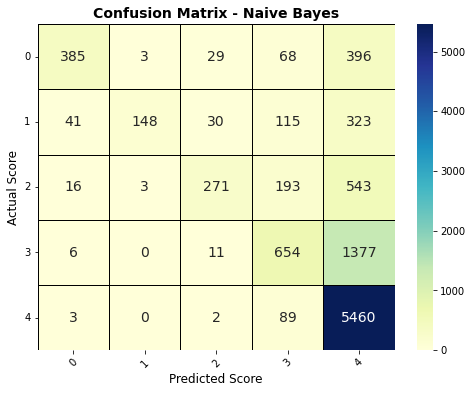

<ipython-input-21-798c2c480986>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(metrics.keys()),  # X-axis: Metric names


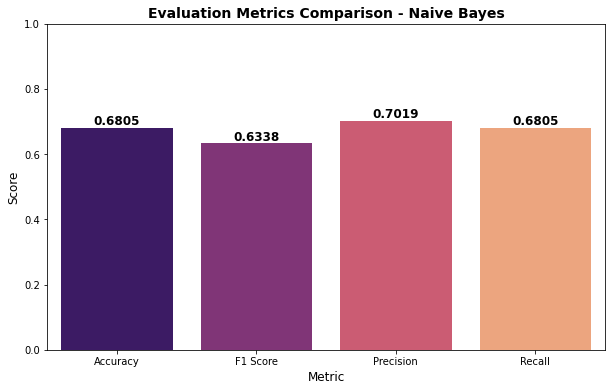


Evaluation Metrics for KNN:
Accuracy: 0.6763
F1 Score: 0.6447
Precision: 0.6513
Recall: 0.6763

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       881
           1       0.53      0.29      0.37       657
           2       0.59      0.33      0.42      1026
           3       0.55      0.34      0.42      2048
           4       0.72      0.93      0.81      5554

    accuracy                           0.68     10166
   macro avg       0.61      0.48      0.52     10166
weighted avg       0.65      0.68      0.64     10166



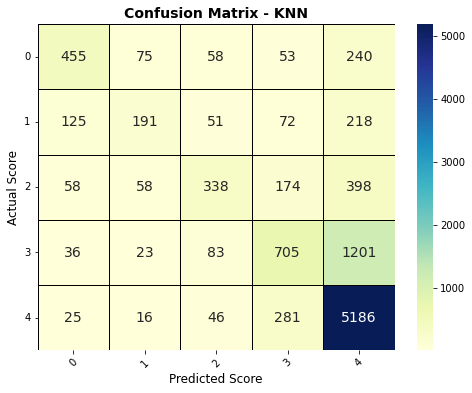

<ipython-input-21-798c2c480986>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(metrics.keys()),  # X-axis: Metric names


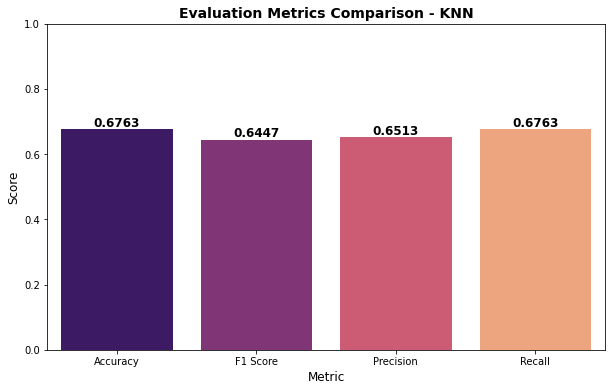


Evaluation Metrics for CNN:
Accuracy: 0.6954
F1 Score: 0.6822
Precision: 0.6815
Recall: 0.6954

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       881
           1       0.38      0.42      0.40       657
           2       0.44      0.43      0.44      1026
           3       0.57      0.39      0.46      2048
           4       0.80      0.91      0.85      5554

    accuracy                           0.70     10166
   macro avg       0.58      0.54      0.56     10166
weighted avg       0.68      0.70      0.68     10166



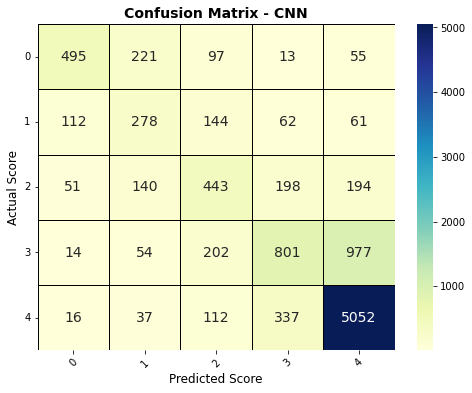

<ipython-input-21-798c2c480986>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(metrics.keys()),  # X-axis: Metric names


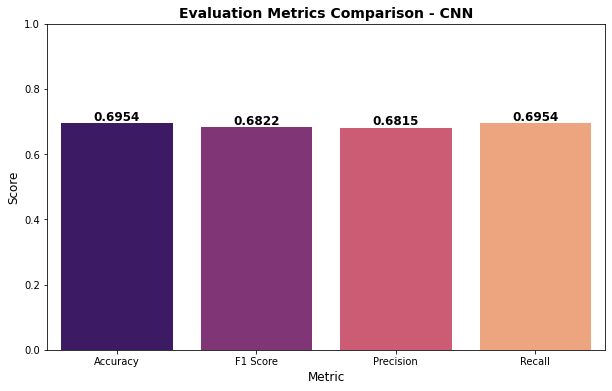


Evaluation Metrics for LSTM:
Accuracy: 0.6809
F1 Score: 0.6715
Precision: 0.6716
Recall: 0.6809

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       881
           1       0.40      0.14      0.20       657
           2       0.39      0.39      0.39      1026
           3       0.46      0.52      0.49      2048
           4       0.83      0.86      0.85      5554

    accuracy                           0.68     10166
   macro avg       0.55      0.51      0.52     10166
weighted avg       0.67      0.68      0.67     10166



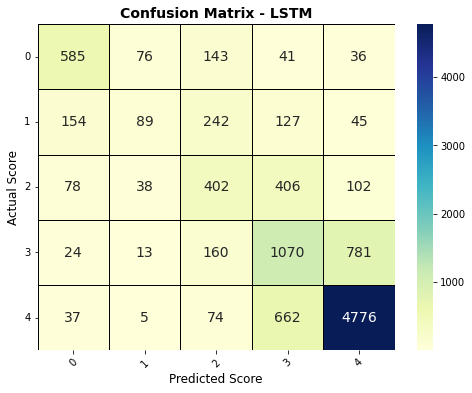

<ipython-input-21-798c2c480986>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(metrics.keys()),  # X-axis: Metric names


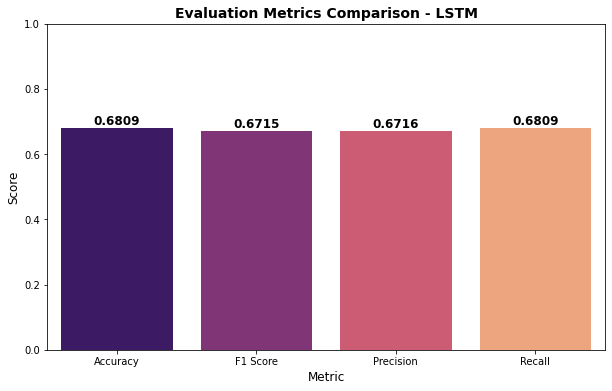

In [21]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates a machine learning model using multiple performance metrics, 
    prints the results, and visualizes the confusion matrix and evaluation metrics.
    
    """
    # Printing the model name in bold text for better visibility
    print(f"\n\033[1mEvaluation Metrics for {model_name}:\033[0m")
    
    # Computing accuracy 
    accuracy = accuracy_score(y_true, y_pred)

    # Computing F1-score 
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Computing precision 
    precision = precision_score(y_true, y_pred, average='weighted')

    # Computing recall
    recall = recall_score(y_true, y_pred, average='weighted')

    # Printing calculated metrics with 4 decimal places for clarity
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # The classification report provides precision, recall, and F1-score for each class
    print("\n\033[1mClassification Report:\033[0m")
    print(classification_report(y_true, y_pred))

    # Computing the confusion matrix (a table showing actual vs. predicted classifications)
    cm = confusion_matrix(y_true, y_pred)

    # Converting the confusion matrix into a pandas DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))

    # Creating a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))  # Setting figure size to improve readability
    sns.heatmap(cm_df,  # Using the confusion matrix dataframe
                annot=True,  # Displaying numbers inside each cell
                fmt='d',  # Formatting numbers as integers
                cmap='YlGnBu',  # Using a blue-green color palette
                linewidths=1,  # Setting the thickness of grid lines
                linecolor='black',  # Setting the grid line color to black
                annot_kws={"size": 14})  # Setting annotation (text) size inside cells

    # Adding a title to the confusion matrix plot
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')

    # Labeling the x-axis and y-axis
    plt.xlabel('Predicted Score', fontsize=12)
    plt.ylabel('Actual Score', fontsize=12)

    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Displaying the confusion matrix heatmap
    plt.show()
    
    # Creating a dictionary to store evaluation metrics
    metrics = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

    # Setting figure size for the bar chart
    plt.figure(figsize=(10, 6))

    # Now, Creating a bar plot with metric names on the x-axis and their values on the y-axis
    ax = sns.barplot(x=list(metrics.keys()),  # X-axis: Metric names
                     y=list(metrics.values()),  # Y-axis: Corresponding values
                     palette="magma")  # Using 'magma' color palette for better visualization

    # Adding a title to the bar chart
    plt.title(f"Evaluation Metrics Comparison - {model_name}", fontsize=14, fontweight='bold')

    # Labeling the axes
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metric', fontsize=12)

    # Setting the y-axis range to ensure values stay between 0 and 1
    plt.ylim(0, 1)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',  # Formatting the value to 4 decimal places
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning the text label
                    ha='center',  # Horizontally center-align text
                    va='bottom',  # Placing text slightly above the bar
                    fontsize=12, fontweight='bold')  # Setting text size and make it bold

    # Displaying the bar chart
    plt.show()

# Evaluating the Naive Bayes model
evaluate_model(y_test, nb_predicted, "Naive Bayes")

# Evaluating the KNN model
evaluate_model(y_test, knn_pred, "KNN")

# Evaluating the CNN model
evaluate_model(y_test, cnn_pred_class, "CNN")

# Evaluating the LSTM model
evaluate_model(y_test, lstm_pred_class, "LSTM")


In [22]:
# Saving Naive Bayes model
# joblib is used to save scikit-learn models efficiently
joblib.dump(nb_model, 'naive_bayes_model.pkl')  
print("Naive Bayes model saved successfully as 'naive_bayes_model.pkl'")

# Similarly, saving KNN model
joblib.dump(final_knn_model, 'knn_model.pkl')  
print("KNN model saved successfully as 'knn_model.pkl'")

# Saving CNN model
# Deep learning models built with TensorFlow/Keras require the .save() method
cnn_model.save('cnn_model.h5')  
print("CNN model saved successfully as 'cnn_model.h5'")

# Saving LSTM model
# Like CNN, LSTM models are also saved using the .save() method 
lstm_model.save('lstm_model.h5')  
print("LSTM model saved successfully as 'lstm_model.h5'")



Naive Bayes model saved successfully as 'naive_bayes_model.pkl'
KNN model saved successfully as 'knn_model.pkl'


/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN model saved successfully as 'cnn_model.h5'
LSTM model saved successfully as 'lstm_model.h5'


In [23]:
with open('tokenizer.pkl', 'wb') as handle:  
    # Using pickle to save (serialize) the 'tokenizer' object into the file
    # 'protocol=pickle.HIGHEST_PROTOCOL' ensures the most efficient way to store the object
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
import joblib 
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Loading the saved tokenizer from the 'tokenizer.pkl' file
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
# Loading the pre-trained deep learning models (CNN & LSTM) using Keras
cnn_model = load_model('cnn_model.h5')  # Loads the CNN model
lstm_model = load_model('lstm_model.h5')  # Loads the LSTM model

# Loading the pre-trained machine learning models (Naive Bayes & KNN) using joblib
nb_model = joblib.load('naive_bayes_model.pkl')  # Loads the Naive Bayes model
knn_model = joblib.load('knn_model.pkl')  # Loads the KNN model

# Defining sequence length for CNN and LSTM models (ensures uniform input size)
CNN_SEQ_LEN = 300  # Maximum sequence length for CNN model
LSTM_SEQ_LEN = 200  # Maximum sequence length for LSTM model

def predict_rating(text, model, model_type):
    
    # If the model is Naive Bayes or KNN, they work with raw text inputs
    if model_type in ['nb', 'knn']:
        return model.predict([text])[0]  # Directly predicting using raw text input
    
    else:
        # Converting text to a sequence of integer tokens using the loaded tokenizer
        seq = tokenizer.texts_to_sequences([text])
        
        # Padding the sequence to a fixed length (CNN or LSTM)
        padded = pad_sequences(seq, maxlen=CNN_SEQ_LEN if model_type == 'cnn' else LSTM_SEQ_LEN)
        
        # Predicting sentiment score using the deep learning model
        pred = model.predict(padded, batch_size=1)
        
        # Getting the index of the highest probability (predicted class)
        return np.argmax(pred, axis=1)[0]


if __name__ == "__main__":
    print("Review Rating Predictor (Please enter 'quit' to exit)")

    while True:
        # Prompt user to enter a review
        text = input("\nPlease enter your review text: ").strip()
        
        # If user types 'quit', exit the loop
        if text.lower() == 'quit':
            break
            
        # Predicting ratings using our 4 models
        print("\nPredicted Ratings according to models:")
        print(f"Naive Bayes: {predict_rating(text, nb_model, 'nb')}")  # Prediction from Naive Bayes
        print(f"KNN: {predict_rating(text, knn_model, 'knn')}")  # Prediction from KNN
        print(f"CNN: {predict_rating(text, cnn_model, 'cnn')}")  # Prediction from CNN
        print(f"LSTM: {predict_rating(text, lstm_model, 'lstm')}")  # Prediction from LSTM


Review Rating Predictor (Please enter 'quit' to exit)

Please enter your review text: product was bad but delivered on time

Predicted Ratings according to models:
Naive Bayes: 4
KNN: 4
1/1 [==============================] - 0s 69ms/step
CNN: 2
1/1 [==============================] - 1s 1s/step
LSTM: 4

Please enter your review text: quit
